
# Synthetic Apple Stock Data Analysis

We simulate 2 years of **Apple stock closing prices** (business days only).  
Steps:
1. Generate synthetic JSON data (with missing values).  
2. Load into pandas DataFrame.  
3. Perform EDA and identify missing values.  
4. Remove missing values.  
5. Visualize with line chart and histogram.  
6. Compute **monthly moving averages** (~21 business days) and overlay.  



## 1. Generate Synthetic JSON Data

Each entry looks like:

```json
{"date": "YYYY-MM-DD", "close": 123.45}
```


In [ ]:

import numpy as np
import pandas as pd
import json

# Generate business day dates for 2 years
dates = pd.date_range(start="2023-01-01", end="2024-12-31", freq="B")

# Simulate closing prices with noise around an upward trend
np.random.seed(42)
trend = np.linspace(150, 200, len(dates))
noise = np.random.normal(0, 5, len(dates))
prices = trend + noise

# Introduce missing values (~5%)
mask = np.random.choice([True, False], size=len(dates), p=[0.05, 0.95])
prices[mask] = np.nan

# Build JSON records
records = [{"date": str(d.date()), "close": (None if np.isnan(p) else round(float(p),2))} 
           for d,p in zip(dates, prices)]

# Save JSON
json_path = "apple_stock.json"
with open(json_path, "w") as f:
    json.dump(records, f, indent=2)

print("Saved JSON to:", json_path)
print(records[:5])


Saved JSON to: apple_stock.json
[{'date': '2023-01-02', 'close': 152.48}, {'date': '2023-01-03', 'close': 149.4}, {'date': '2023-01-04', 'close': 153.43}, {'date': '2023-01-05', 'close': 157.9}, {'date': '2023-01-06', 'close': 149.21}]


## 2. Load JSON into Pandas

In [6]:

with open(json_path) as f:
    data = json.load(f)

df = pd.DataFrame(data)
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

# Display both head and tail of the DataFrame
print("Head of the DataFrame:")
print(df.head())

print("\nTail of the DataFrame:")
print(df.tail())


Head of the DataFrame:
             close
date              
2023-01-02  152.48
2023-01-03  149.40
2023-01-04  153.43
2023-01-05  157.90
2023-01-06  149.21

Tail of the DataFrame:
             close
date              
2024-12-25  194.73
2024-12-26  200.21
2024-12-27  203.56
2024-12-30  191.56
2024-12-31  202.72


## Refresher: SQL with Python and MySQL

### Objective:
We'll cover:
1. Establishing a connection to a MySQL server.
2. Writing and executing SQL queries.
3. Fetching and previewing query results in a pandas DataFrame.

### Key Concepts:
- **Connection**: Use `mysql.connector` to connect to a MySQL server.
- **Query Execution**: Write SQL queries and execute them using Python.
- **Data Preview**: Fetch query results and display them in a pandas DataFrame for analysis.

### Why Use Python for SQL?
- Python provides flexibility to automate database operations.
- Pandas integration allows easy manipulation and visualization of query results.

In [ ]:
import mysql.connector
import pandas as pd

# Establish connection to local MySQL server
conn = mysql.connector.connect(
    host="localhost",
    user="root",       # classroom demo only
    password="William2025!!",   # replace in real deployments
)
print(f"Connected to MySQL server version {conn.server_info}")

def run_query(sql: str, params: tuple = None, preview: int = 10):
    """
    Execute SQL and return a pandas DataFrame (optionally preview head).
    Automatically commits changes for modifying queries (INSERT, UPDATE, DELETE).
    """
    cur = conn.cursor()
    cur.execute(sql, params or ())
    
    # Commit changes for modifying queries
    if sql.strip().upper().startswith(("INSERT", "UPDATE", "DELETE")):
        conn.commit()
    
    # Fetch rows for SELECT queries
    rows = cur.fetchall()
    cols = [d[0] for d in cur.description] if cur.description else []
    cur.close()
    
    # Return DataFrame for SELECT queries
    if rows:
        df = pd.DataFrame(rows, columns=cols)
        return df.head(preview) if preview is not None else df
    else:
        return pd.DataFrame()  # Return empty DataFrame for non-SELECT queries

Connected to MySQL server


In [ ]:
# Drop the database if it exists
run_query("DROP DATABASE IF EXISTS apple_stock;")

# Create the database
run_query("CREATE DATABASE apple_stock;")

# Switch to the new database
conn.database = "apple_stock"
print("Database 'apple_stock' created and selected.")

Database 'apple_stock' created and selected.


In [ ]:
# Create the table for storing stock data
run_query("""
CREATE TABLE IF NOT EXISTS stock_data (
    date DATE NOT NULL,
    close FLOAT
);
""")
print("Table 'stock_data' created.")

Table 'stock_data' created.


## 3. Exploratory Data Analysis & Missing Values

In [1]:
df.info()

NameError: name 'df' is not defined

In [21]:
# count missing values
df.isnull().sum()

close    27
dtype: int64

## 4. Remove Missing Values

In [22]:

df_clean = df.dropna()
df_clean.head()


,close
date,
2023-01-02,152.48
2023-01-03,149.40
2023-01-04,153.43
2023-01-05,157.90
2023-01-06,149.21


In [23]:
 
# Insert data from the cleaned DataFrame into the table
insert_query = "INSERT INTO stock_data (date, close) VALUES (%s, %s)"
for index, row in df_clean.iterrows():
    run_query(insert_query, (index.date(), row["close"]))

print("Data inserted into 'stock_data' table.")

Data inserted into 'stock_data' table.


In [24]:
# Query the data from the database
query = "SELECT * FROM stock_data;"
df_from_db = run_query(query, preview=None)

# Set the 'date' column as the index
df_from_db["date"] = pd.to_datetime(df_from_db["date"])
df_from_db.set_index("date", inplace=True)

# Display the DataFrame
print("Data read from the database:")
print(df_from_db.head())

Data read from the database:
             close
date              
2023-01-02  152.48
2023-01-03  149.40
2023-01-04  153.43
2023-01-05  157.90
2023-01-06  149.21


## 5. Visualize Data

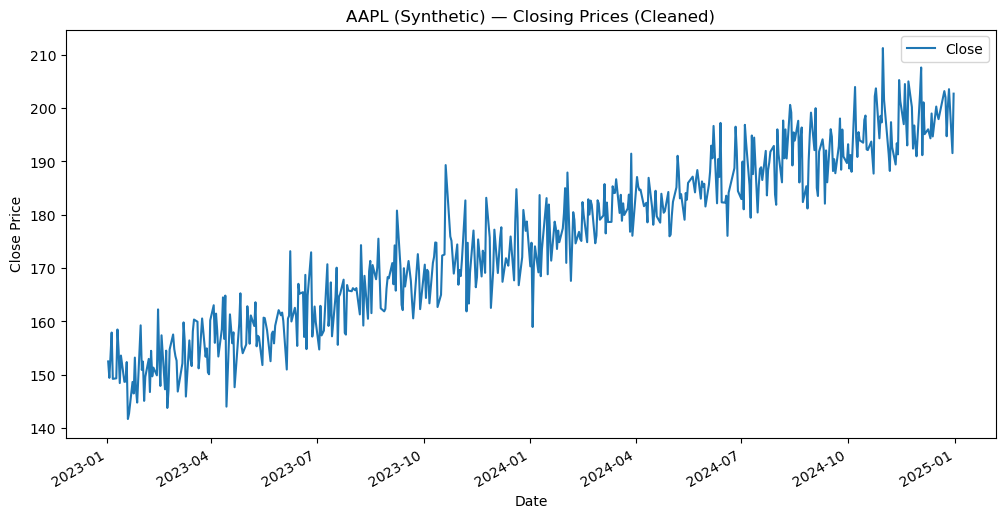

In [25]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Make the figure wider
plt.plot(df_from_db.index, df_from_db["close"], label="Close")
plt.title("AAPL (Synthetic) — Closing Prices (Cleaned)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()

# Format x-axis to display months
plt.gcf().autofmt_xdate()  # Automatically format x-axis for better readability

plt.show()

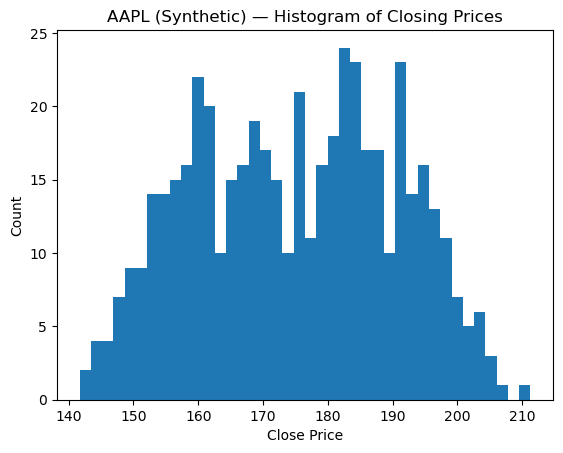

In [26]:

plt.figure()
plt.hist(df_from_db["close"], bins=40)
plt.title("AAPL (Synthetic) — Histogram of Closing Prices")
plt.xlabel("Close Price")
plt.ylabel("Count")
plt.show()


## 6. Monthly Moving Average (~21 business days)

## Moving Average: Explanation and Application

### What is a Moving Average?
A **moving average** is a statistical technique used to smooth out short-term fluctuations in data and highlight longer-term trends. It calculates the average of a subset of data points over a specified window size, which "moves" as new data points are added.

### Mathematical Formula:
For a time series $ x_1, x_2, \dots, x_n $, the moving average at time $ t $ with a window size $ w $ is given by:

$$
MA_t = \frac{1}{w} \sum_{i=t-w+1}^{t} x_i
$$

Where:
- $ MA_t $: Moving average at time \( t \)
- $ w $: Window size (number of data points to average)
- $ x_i $: Data point at time \( i \)

### Application to the Data:
1. **Window Size**:
   - We use a window size of 21 business days (approximately one month) to calculate the moving average for the closing prices.

2. **Step-by-Step Process**:
   - For each date, take the closing prices of the previous 21 business days.
   - Compute the average of these prices.
   - Assign this average as the moving average for the current date.

3. **Visualization**:
   - The moving average is plotted alongside the original closing prices to show the smoothed trend.

### Why Use Moving Averages?
- **Trend Identification**: Helps identify long-term trends in stock prices.
- **Noise Reduction**: Reduces the impact of short-term fluctuations caused by random events.
- **Decision Making**: Often used in financial analysis to make trading decisions.

---

In [28]:
df_from_db = df_from_db.sort_index()
df_from_db["ma_21b"] = df_from_db["close"].rolling(window=21, min_periods=1).mean()

df




,close
date,
2023-01-02,152.48
2023-01-03,149.40
2023-01-04,153.43
2023-01-05,157.90
2023-01-06,149.21
...,...
2024-12-25,194.73
2024-12-26,200.21
2024-12-27,203.56


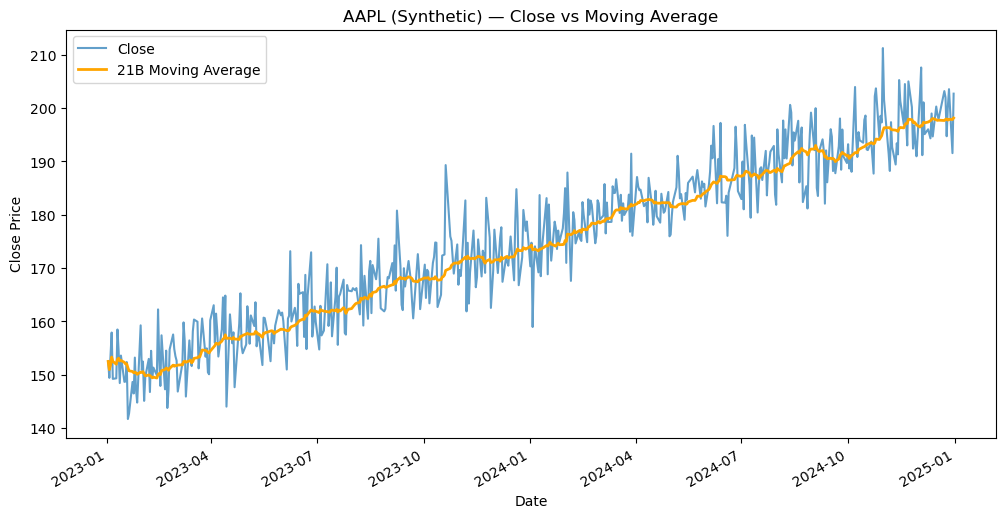

In [29]:

plt.figure(figsize=(12, 6))  # Make the figure wider
plt.plot(df_from_db.index, df_from_db["close"], label="Close", alpha=0.7)
plt.plot(df_from_db.index, df_from_db["ma_21b"], label="21B Moving Average", linewidth=2, color="orange")
plt.title("AAPL (Synthetic) — Close vs Moving Average")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()

# Format x-axis to display months
plt.gcf().autofmt_xdate()  # Automatically format x-axis for better readability

plt.show()

## Prescriptive Analytics: Buy/Sell Recommendations Based on Moving Average

### Explanation of the Code:
This code uses **prescriptive analytics** to provide actionable recommendations (Buy, Sell, or Hold) based on the moving average of stock prices. The logic is as follows:

1. **Thresholds**:
   - A **Buy** recommendation is made if the moving average exceeds the `buy_threshold` (e.g., 180).
   - A **Sell** recommendation is made if the moving average falls below the `sell_threshold` (e.g., 160).
   - Otherwise, the recommendation is to **Hold**.

2. **Action Column**:
   - A new column `action` is added to the DataFrame, storing the prescribed action for each date based on the moving average.

3. **Visualization**:
   - The closing prices and moving average are plotted.
   - Buy points are highlighted with green upward triangles.
   - Sell points are highlighted with red downward triangles.

### Why Use Prescriptive Analytics?
- **Actionable Insights**: Helps investors make informed decisions based on trends in stock prices.
- **Threshold-Based Decision Making**: Simplifies complex data into clear recommendations.
- **Visualization**: Provides a clear view of when to buy, sell, or hold based on historical trends.

This approach combines statistical analysis with actionable recommendations, making it a powerful tool for decision-making in

In [30]:
# Define thresholds for prescriptive analytics
buy_threshold = 180
sell_threshold = 160

# Analyze moving average and prescribe actions
df_from_db["action"] = df_from_db["ma_21b"].apply(
    lambda ma: "Buy" if ma > buy_threshold else ("Sell" if ma < sell_threshold else "Hold")
)

# Display the first few rows with prescribed actions
print(df_from_db[["close", "ma_21b", "action"]].head())



             close    ma_21b action
date                               
2023-01-02  152.48  152.4800   Sell
2023-01-03  149.40  150.9400   Sell
2023-01-04  153.43  151.7700   Sell
2023-01-05  157.90  153.3025   Sell
2023-01-06  149.21  152.4840   Sell


In [32]:
from datetime import datetime

# Generate a dynamic table name based on the current date
current_date = datetime.now().strftime("%Y_%m_%d")
table_name = f"actions_{current_date}"

# Create the table dynamically
run_query(f"""
CREATE TABLE IF NOT EXISTS {table_name} (
    date DATE NOT NULL,
    close FLOAT,
    ma_21b FLOAT,
    action VARCHAR(10)
);
""")

# Insert the current actions into the dynamically named table
insert_actions_query = f"""
INSERT INTO {table_name} (date, close, ma_21b, action)
VALUES (%s, %s, %s, %s)
"""

for idx, row in df_from_db.iterrows():
    run_query(insert_actions_query, (idx.date(), row["close"], row["ma_21b"], row["action"]))

print(f"Actions stored in '{table_name}' table.")

Actions stored in 'actions_2025_08_27' table.


KeyError: 'action'

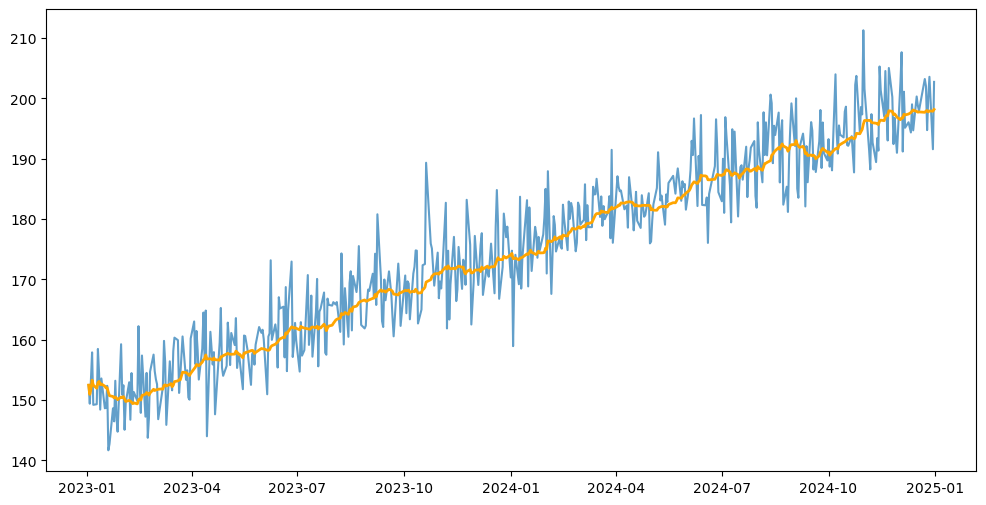

In [33]:

# Visualize the prescribed actions
plt.figure(figsize=(12, 6))
plt.plot(df_clean.index, df_clean["close"], label="Close", alpha=0.7)
plt.plot(df_clean.index, df_clean["ma_21b"], label="21B Moving Average", linewidth=2, color="orange")

# Highlight buy/sell points
buy_points = df_clean[df_clean["action"] == "Buy"]
sell_points = df_clean[df_clean["action"] == "Sell"]
plt.scatter(buy_points.index, buy_points["close"], color="green", label="Buy", marker="^", s=100)
plt.scatter(sell_points.index, sell_points["close"], color="red", label="Sell", marker="v", s=100)

plt.title("AAPL (Synthetic) — Prescriptive Analytics: Buy/Sell Recommendations")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()